# Problem: Predicting Airplane Delays

The goals of this notebook are:
- Process and create a dataset from downloaded ZIP files
- Exploratory data analysis (EDA)
- Establish a baseline model and improve it

## Introduction to business scenario
You work for a travel booking website that is working to improve the customer experience for flights that were delayed. The company wants to create a feature to let customers know if the flight will be delayed due to weather when the customers are booking the flight to or from the busiest airports for domestic travel in the US. 

You are tasked with solving part of this problem by leveraging machine learning to identify whether the flight will be delayed due to weather. You have been given access to the a dataset of on-time performance of domestic flights operated by large air carriers. You can use this data to train a machine learning model to predict if the flight is going to be delayed for the busiest airports.

### Dataset
The provided dataset contains scheduled and actual departure and arrival times reported by certified US air carriers that account for at least 1 percent of domestic scheduled passenger revenues. The data was collected by the Office of Airline Information, Bureau of Transportation Statistics (BTS). The dataset contains date, time, origin, destination, airline, distance, and delay status of flights for flights between 2014 and 2018.
The data are in 60 compressed files, where each file contains a CSV for the flight details in a month for the five years (from 2014 - 2018). The data can be downloaded from this link: [https://ucstaff-my.sharepoint.com/:f:/g/personal/ibrahim_radwan_canberra_edu_au/Er0nVreXmihEmtMz5qC5kVIB81-ugSusExPYdcyQTglfLg?e=bNO312]. Please download the data files and place them on a relative path. Dataset(s) used in this assignment were compiled by the Office of Airline Information, Bureau of Transportation Statistics (BTS), Airline On-Time Performance Data, available with the following link: [https://www.transtats.bts.gov/Fields.asp?gnoyr_VQ=FGJ]. 

# Step 1: Problem formulation and data collection

Start this project off by writing a few sentences below that summarize the business problem and the business goal you're trying to achieve in this scenario. Include a business metric you would like your team to aspire toward. With that information defined, clearly write out the machine learning problem statement. Finally, add a comment or two about the type of machine learning this represents. 


### 1. Determine if and why ML is an appropriate solution to deploy.

Looking at the data available, and the scenario, Machine learning is suitiable. because its ability to analyze large datasets and idenfity patterns that can predict future flights.  traditional rule base not suitable.  ML can process vast historical flight data analyze large number of features simulataneously, like weather, airports, times, dates etc. then learn complex patterns that might lead to delays, makeing it an idea solution to predict future flight delays. 

### 2. Formulate the business problem, success metrics, and desired ML output.

**Business Problem:** The company aiming to provide indicative information about potential flight delays during booking process, in order to improve customer satisfaction. This level of openness is expected to improve customer experience by preparing customers in advance for delay that are sometimes unavoidable. 


**Success Metrics:** for success metrics, from business side, it would be a rise increase in client satisfaction, increased number of positive feedbacks, and a decline in both negative feedbacks and complaints about the flight delays. 
From a technical side, it entails achieving a high accuracy in predicting flight delays and minimized false negative. This is very important, because inform customers incorrectly that flight would be on time, but actually delayed, will increase the likelihood of complaint and reduced trust in this solution. 

**ML Output:** The desired output would be a good accuracy of the model, that can provide a reliable prediction for flight delays. 

### 3. Identify the type of ML problem you’re dealing with.

This is a supervised learning problem, specifically a binary classification task, predict whether a flight will be delayed or not. The model will be trained using historical flight data, including known outcomes, the delay indicator, to learn the correlation between different features and the likelihood of a delay, it serves like a labeled dataset, then include futher weather data, to train and subsequently evaluate its predictive performance.

### Setup

Now that we have decided where to focus our energy, let's set things up so you can start working on solving the problem.

In [1]:
import subprocess
import sys
import importlib

# List of libraries to check
libraries = ['subprocess', 'sys', 'pandas', 'numpy', 'matplotlib', 'seaborn', 'dask', 'scikit-learn', 'zipfile', 'pathlib2', 'pathlib', 'warnings', 'glob']

#initial run into problem, as pip install uses scikit-learn, but import requires sklearn.
package_name_mapping = {
    'scikit-learn': 'sklearn',
}

def import_or_install(package):
    try:
        import_name = package_name_mapping.get(package, package)
        # Try to import the module
        importlib.import_module(import_name)
        print(f"{package} is already installed")

    except ImportError:
        # Handle the standard library and third-party libraries differently
        if package in ['subprocess', 'sys', 'zipfile', 'warnings', 'glob', 'pathlib']:
            print(f"Standard library {package} is missing, which is unexpected. Please ensure a valid Python installation.")
        else:
            print(f"{package} not found. Trying to install...")
            try:
                subprocess.check_call([sys.executable, "-m", "pip", "install", package])
                
                # After installation, the module should be imported
                importlib.import_module(import_name)
            except subprocess.CalledProcessError as e:
                print(f"An error occurred while installing the package: {package}. Error: {str(e)}")

    except Exception as e:
        print(f"An error occurred while checking the package: {package}. Error: {str(e)}")

# Check each library in the list
for library in libraries:
    import_or_install(library)


subprocess is already installed
sys is already installed
pandas is already installed
numpy is already installed
matplotlib is already installed
seaborn is already installed
dask is already installed
scikit-learn is already installed
zipfile is already installed
pathlib2 is already installed
pathlib is already installed
warnings is already installed
glob is already installed


In [2]:
import os
from pathlib2 import Path
from zipfile import ZipFile
import time

import pandas as pd
import numpy as np
import subprocess

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline



# Step 2: Data preprocessing and visualization  
In this data preprocessing phase, you should take the opportunity to explore and visualize your data to better understand it. First, import the necessary libraries and read the data into a Pandas dataframe. After that, explore your data. Look for the shape of the dataset and explore your columns and the types of columns you're working with (numerical, categorical). Consider performing basic statistics on the features to get a sense of feature means and ranges. Take a close look at your target column and determine its distribution.

### Specific questions to consider
1. What can you deduce from the basic statistics you ran on the features? 

2. What can you deduce from the distributions of the target classes?

3. Is there anything else you deduced from exploring the data?

Start by bringing in the dataset from an Amazon S3 public bucket to this notebook environment.

In [3]:
from pathlib import Path
import zipfile
import os

In [4]:
# download the files
# downloaded file data_compressed.zip 

# <note: make them all relative, absolute path is not accepted>
base_path = Path().resolve() #relative base path of project directory

zip_path = "data_compressed.zip" #relative path to the "data_compressed.zip" 
csv_base_path = "data_extracted" #relative path to the "data_extracted" directory

os.makedirs(csv_base_path, exist_ok=True) 

In [12]:
# How many zip files do we have? write a code to answer it.

def count_zip_files(directory):
    zip_count = 0
    # Open the zip file to check files end with zip.
    with zipfile.ZipFile(directory, 'r') as zip_ref:
        for file in zip_ref.namelist():
            if file.endswith('.zip'):
                zip_count += 1
    return zip_count

#get the total number of zip files from zip path. 
number_of_zip_files = count_zip_files(base_path / zip_path)

print(f"There are {number_of_zip_files} zip files within the zip path: {zip_path}")


There are 60 zip files within the zip path: data_compressed.zip


#### Extract CSV files from ZIP files

In [13]:
def zip2csv(zip_path , csv_base_path, base_path):
    """
    Extract csv from zip files
    zipFile_name: name of the zip file --> zip_path
    file_path : name of the folder to store csv --> csv_base_path
    """
    # Extract the main zip file
    with zipfile.ZipFile(base_path / zip_path, 'r') as main_zip:
        main_zip.extractall(path=base_path)
        print(f"Main zip file {zip_path} extracted.")
    
    extracted_folder = base_path / "data_compressed"

    # Find and extract each inner zip file
    for zip_file in extracted_folder.rglob('*.zip'):
        with zipfile.ZipFile(zip_file, 'r') as sub_zip:
            # Extract inner zip files to the same csv base directory
            sub_zip.extractall(path=base_path / csv_base_path)
            print(f"Extracted {zip_file} to {csv_base_path}")

    print("All files extracted.")

zip2csv(zip_path , csv_base_path, base_path)

Main zip file data_compressed.zip extracted.
Extracted C:\Users\chen\Final_project\data_compressed\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_1.zip to data_extracted
Extracted C:\Users\chen\Final_project\data_compressed\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_10.zip to data_extracted
Extracted C:\Users\chen\Final_project\data_compressed\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_11.zip to data_extracted
Extracted C:\Users\chen\Final_project\data_compressed\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_12.zip to data_extracted
Extracted C:\Users\chen\Final_project\data_compressed\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_2.zip to data_extracted
Extracted C:\Users\chen\Final_project\data_compressed\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_3.zip to data_extracted
Extracted C:\Users\chen\Final_project\data_compressed\On_Time_Reporting_Carrier_On_Time_Performance_

Extracted C:\Users\chen\Final_project\data_compressed\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2018_8.zip to data_extracted
Extracted C:\Users\chen\Final_project\data_compressed\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2018_9.zip to data_extracted
All files extracted.


In [14]:
# How many csv files have we extracted? write a code to answer it.
def count_csv_files(directory):
    csv_files = list(directory.rglob('*.csv'))
    return len(csv_files)

#get the total number of csv files from csv base path. 
number_of_csv_files = count_csv_files(base_path / csv_base_path)

print(f"There are {number_of_csv_files} csv files has been extracted into the csv path: { csv_base_path}")


There are 60 csv files has been extracted into the csv path: data_extracted


Before loading the CSV file, read the HTML file from the extracted folder. This HTML file includes the background and more information on the features included in the dataset.

In [15]:
file_path = os.path.join(csv_base_path, "readme.html")
html_relative_path = os.path.relpath(file_path)

In [16]:
from IPython.display import IFrame

IFrame(src=os.path.relpath(html_relative_path), width=1000, height=600)

#### Load sample CSV

Before combining all the CSV files, get a sense of the data from a single CSV file. Using Pandas, read the `On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_9.csv` file first. You can use the Python built-in `read_csv` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)).

In [17]:
df_temp = pd.read_csv('data_extracted\On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_9.csv')

**Question**: Print the row and column length in the dataset, and print the column names.

In [18]:
df_shape = df_temp.shape
print(f'Rows and columns in one csv file is {df_shape}')

Rows and columns in one csv file is (585749, 110)


**Question**: Print the first 10 rows of the dataset.  

In [19]:
df_temp.head(10)

Year  Quarter  Month  DayofMonth  DayOfWeek  FlightDate Reporting_Airline  \
0  2018        3      9           3          1  2018-09-03                9E   
1  2018        3      9           9          7  2018-09-09                9E   
2  2018        3      9          10          1  2018-09-10                9E   
3  2018        3      9          13          4  2018-09-13                9E   
4  2018        3      9          14          5  2018-09-14                9E   
5  2018        3      9          16          7  2018-09-16                9E   
6  2018        3      9          17          1  2018-09-17                9E   
7  2018        3      9          20          4  2018-09-20                9E   
8  2018        3      9          21          5  2018-09-21                9E   
9  2018        3      9          23          7  2018-09-23                9E   

   DOT_ID_Reporting_Airline IATA_CODE_Reporting_Airline Tail_Number  ...  \
0                     20363                          9E      N908XJ  ...   
1                     20363                          9E      N315PQ  ...   
2                     20363                          9E      N582CA  ...   
3                     20363                          9E      N292PQ  ...   
4                     20363                          9E      N600LR  ...   
5                     20363                          9E      N316PQ  ...   
6                     20363                          9E      N916XJ  ...   
7                     20363                          9E      N371CA  ...   
8                     20363                          9E      N601LR  ...   
9                     20363                          9E      N906XJ  ...   

   Div4TailNum  Div5Airport  Div5AirportID  Div5AirportSeqID Div5WheelsOn  \
0          NaN          NaN            NaN               NaN          NaN   
1          NaN          NaN            NaN               NaN          NaN   
2          NaN          NaN            NaN               NaN          NaN   
3          NaN          NaN            NaN               NaN          NaN   
4          NaN          NaN            NaN               NaN          NaN   
5          NaN          NaN            NaN               NaN          NaN   
6          NaN          NaN            NaN               NaN          NaN   
7          NaN          NaN            NaN               NaN          NaN   
8          NaN          NaN            NaN               NaN          NaN   
9          NaN          NaN            NaN               NaN          NaN   

  Div5TotalGTime Div5LongestGTime  Div5WheelsOff Div5TailNum  Unnamed: 109  
0            NaN              NaN            NaN         NaN           NaN  
1            NaN              NaN            NaN         NaN           NaN  
2            NaN              NaN            NaN         NaN           NaN  
3            NaN              NaN            NaN         NaN           NaN  
4            NaN              NaN            NaN         NaN           NaN  
5            NaN              NaN            NaN         NaN           NaN  
6            NaN              NaN            NaN         NaN           NaN  
7            NaN              NaN            NaN         NaN           NaN  
8            NaN              NaN            NaN         NaN           NaN  
9            NaN              NaN            NaN         NaN           NaN  

[10 rows x 110 columns]

**Question**: Print all the columns in the dataset. Use `<dataframe>.columns` to view the column names.

In [20]:
print(f'The column names are :')
print('#########')
for col in df_temp.columns:
    print(col)

The column names are :
#########
Year
Quarter
Month
DayofMonth
DayOfWeek
FlightDate
Reporting_Airline
DOT_ID_Reporting_Airline
IATA_CODE_Reporting_Airline
Tail_Number
Flight_Number_Reporting_Airline
OriginAirportID
OriginAirportSeqID
OriginCityMarketID
Origin
OriginCityName
OriginState
OriginStateFips
OriginStateName
OriginWac
DestAirportID
DestAirportSeqID
DestCityMarketID
Dest
DestCityName
DestState
DestStateFips
DestStateName
DestWac
CRSDepTime
DepTime
DepDelay
DepDelayMinutes
DepDel15
DepartureDelayGroups
DepTimeBlk
TaxiOut
WheelsOff
WheelsOn
TaxiIn
CRSArrTime
ArrTime
ArrDelay
ArrDelayMinutes
ArrDel15
ArrivalDelayGroups
ArrTimeBlk
Cancelled
CancellationCode
Diverted
CRSElapsedTime
ActualElapsedTime
AirTime
Flights
Distance
DistanceGroup
CarrierDelay
WeatherDelay
NASDelay
SecurityDelay
LateAircraftDelay
FirstDepTime
TotalAddGTime
LongestAddGTime
DivAirportLandings
DivReachedDest
DivActualElapsedTime
DivArrDelay
DivDistance
Div1Airport
Div1AirportID
Div1AirportSeqID
Div1WheelsOn
Div1

**Question**: Print all the columns in the dataset that contain the word 'Del'. This will help you see how many columns have delay data in them.

**Hint**: You can use a Python list comprehension to include values that pass certain `if` statement criteria.

For example: `[x for x in [1,2,3,4,5] if x > 2]`  

**Hint**: You can use the `in` keyword ([documentation](https://www.w3schools.com/python/ref_keyword_in.asp)) to check if the value is in a list or not. 

For example: `5 in [1,2,3,4,5]`

In [21]:
delay_columns = [col for col in df_temp.columns if 'Del' in col]
print(delay_columns)

['DepDelay', 'DepDelayMinutes', 'DepDel15', 'DepartureDelayGroups', 'ArrDelay', 'ArrDelayMinutes', 'ArrDel15', 'ArrivalDelayGroups', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'DivArrDelay']


Here are some more questions to help you find out more about your dataset.

**Questions**   
1. How many rows and columns does the dataset have?   
2. How many years are included in the dataset?   
3. What is the date range for the dataset?   
4. Which airlines are included in the dataset?   
5. Which origin and destination airports are covered?

In [22]:
# to answer above questions, complete the following code
print("The #rows and #columns are ", len(df_temp) , " and ", len(df_temp.columns))
print("The years in this dataset are: ", df_temp['Year'].unique())
print("The months covered in this dataset are: ", df_temp['Month'].unique())
print("The date range for data is :" , min(df_temp['FlightDate']), " to ", max(df_temp['FlightDate']))
print("The airlines covered in this dataset are: ", list(df_temp['Reporting_Airline'].unique()))
print("The Origin airports covered are: ", list(df_temp['Origin'].unique()))
print("The Destination airports covered are: ", list(df_temp['Dest'].unique()))

The #rows and #columns are  585749  and  110
The years in this dataset are:  [2018]
The months covered in this dataset are:  [9]
The date range for data is : 2018-09-01  to  2018-09-30
The airlines covered in this dataset are:  ['9E', 'B6', 'WN', 'YV', 'YX', 'EV', 'AA', 'AS', 'DL', 'HA', 'UA', 'F9', 'G4', 'MQ', 'NK', 'OH', 'OO']
The Origin airports covered are:  ['DFW', 'LGA', 'MSN', 'MSP', 'ATL', 'BDL', 'VLD', 'JFK', 'RDU', 'CHS', 'DTW', 'GRB', 'PVD', 'SHV', 'FNT', 'PIT', 'RIC', 'RST', 'RSW', 'CVG', 'LIT', 'ORD', 'JAX', 'TRI', 'BOS', 'CWA', 'DCA', 'CHO', 'AVP', 'IND', 'GRR', 'BTR', 'MEM', 'TUL', 'CLE', 'STL', 'BTV', 'OMA', 'MGM', 'TVC', 'SAV', 'GSP', 'EWR', 'OAJ', 'BNA', 'MCI', 'TLH', 'ROC', 'LEX', 'PWM', 'BUF', 'AGS', 'CLT', 'GSO', 'BWI', 'SAT', 'PHL', 'TYS', 'ACK', 'DSM', 'GNV', 'AVL', 'BGR', 'MHT', 'ILM', 'MOT', 'IAH', 'SBN', 'SYR', 'ORF', 'MKE', 'XNA', 'MSY', 'PBI', 'ABE', 'HPN', 'EVV', 'ALB', 'LNK', 'AUS', 'PHF', 'CHA', 'GTR', 'BMI', 'BQK', 'CID', 'CAK', 'ATW', 'ABY', 'CAE', 'SRQ

**Question**: What is the count of all the origin and destination airports?

**Hint**: You can use the Pandas `values_count` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html)) to find out the values for each airport using the columns `Origin` and `Dest`.

In [23]:
counts = pd.DataFrame({'Origin':df_temp['Origin'].value_counts(), 
                       'Destination':df_temp['Dest'].value_counts()})
counts

Origin  Destination
ABE     303          303
ABI     169          169
ABQ    2077         2076
ABR      60           60
ABY      79           79
..      ...          ...
WRG      60           60
WYS      52           52
XNA    1004         1004
YAK      60           60
YUM      96           96

[346 rows x 2 columns]

**Question**: Print the top 15 origin and destination airports based on number of flights in the dataset.

**Hint**: You can use the Pandas `sort_values` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html)).

In [24]:
counts.sort_values(by=['Origin'],ascending=False).head(15 )# Enter your code here

Origin  Destination
ATL   31525        31521
ORD   28257        28250
DFW   22802        22795
DEN   19807        19807
CLT   19655        19654
LAX   17875        17873
SFO   14332        14348
IAH   14210        14203
LGA   13850        13850
MSP   13349        13347
LAS   13318        13322
PHX   13126        13128
DTW   12725        12724
BOS   12223        12227
SEA   11872        11877

**Question**: Given all the information about a flight trip, can you predict if it would be delayed?

**Answer** Predicting flight delay involves building a model, takes features of a flight, then predicts if it will be delayed. I can not predict directly from the data in the dataset, but given the information available from the dataset, especially it contains several features about the flight also the delay matrics, it is possible to build a model to predict if the flight would be delayed. 
I would pre-preprocess the data first (missing values, inconsistent data etc.) encoding the categorical data, then perform EDA on prepared data, then create a model for the prediction.


Now, assume you are traveling from San Francisco to Los Angeles on a work trip. You want to have an ideas if your flight will be delayed, given a set of features, so that you can manage your reservations in Los Angeles better. How many features from this dataset would you know before your flight?

Columns such as `DepDelay`, `ArrDelay`, `CarrierDelay`, `WeatherDelay`, `NASDelay`, `SecurityDelay`, `LateAircraftDelay`, and `DivArrDelay` contain information about a delay. But this delay could have occured at the origin or destination. If there were a sudden weather delay 10 minutes before landing, this data would not be helpful in managing your Los Angeles reservations.

So to simplify the problem statement, consider the following columns to predict an arrival delay:<br>

`Year`, `Quarter`, `Month`, `DayofMonth`, `DayOfWeek`, `FlightDate`, `Reporting_Airline`, `Origin`, `OriginState`, `Dest`, `DestState`, `CRSDepTime`, `DepDelayMinutes`, `DepartureDelayGroups`, `Cancelled`, `Diverted`, `Distance`, `DistanceGroup`, `ArrDelay`, `ArrDelayMinutes`, `ArrDel15`, `AirTime`

You will also filter the source and destination airports to be:
- Top airports: ATL, ORD, DFW, DEN, CLT, LAX, IAH, PHX, SFO
- Top 5 airlines: UA, OO, WN, AA, DL

This should help in reducing the size of data across the CSV files to be combined.

#### Combine all CSV files

**Hint**:  
First, create an empy dataframe that you will use to copy your individual dataframes from each file. Then, for each file in the `csv_files` list:

1. Read the CSV file into a dataframe  
2. Filter the columns based on the `filter_cols` variable

```
        columns = ['col1', 'col2']
        df_filter = df[columns]
```

3. Keep only the subset_vals in each of the subset_cols. Use the `isin` Pandas function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.isin.html)) to check if the `val` is in the dataframe column and then choose the rows that include it.

```
        df_eg[df_eg['col1'].isin('5')]
```

4. Concatenate the dataframe with the empty dataframe 

In [25]:
def combine_csv(csv_files, filter_cols, subset_cols, subset_vals, file_name):
    """
    Combine csv files into one Data Frame
    csv_files: list of csv file paths
    filter_cols: list of columns to filter
    subset_cols: list of columns to subset rows
    subset_vals: list of list of values to subset rows
    """
    # Create an empty dataframe
    combined_df = pd.DataFrame()
    
    dir_name = os.path.join(base_path, 'data_extracted')
    
    # Process each file from the list of csc file paths
    for file_path in csv_files:
        # Read the current file into a DataFrame
        df = pd.read_csv(file_path)

        # Filter columns
        df = df[filter_cols]

        # Filter rows
        for col, vals in zip(subset_cols, subset_vals):
            df = df[df[col].isin(vals)]

        # Concatenate the current DataFrame with the combined DataFrame
        combined_df = pd.concat([combined_df, df], ignore_index=True)

    # Save the combined dataframe to a csv file
    combined_df.to_csv(combined_csv_filename, index=False)

    return combined_df  # return the dataframe 



In [26]:
#cols is the list of columns to predict Arrival Delay 
cols = ['Year','Quarter','Month','DayofMonth','DayOfWeek','FlightDate',
        'Reporting_Airline','Origin','OriginState','Dest','DestState',
        'CRSDepTime','Cancelled','Diverted','Distance','DistanceGroup',
        'ArrDelay','ArrDelayMinutes','ArrDel15','AirTime']

subset_cols = ['Origin', 'Dest', 'Reporting_Airline']

# subset_vals is a list collection of the top origin and destination airports and top 5 airlines
subset_vals = [['ATL', 'ORD', 'DFW', 'DEN', 'CLT', 'LAX', 'IAH', 'PHX', 'SFO'], 
               ['ATL', 'ORD', 'DFW', 'DEN', 'CLT', 'LAX', 'IAH', 'PHX', 'SFO'], 
               ['UA', 'OO', 'WN', 'AA', 'DL']]

Use the function above to merge all the different files into a single file that you can read easily. 

**Note**: This will take 5-7 minutes to complete.

In [27]:
start = time.time()

combined_csv_filename = os.path.join(base_path, "combined_files.csv")

dir_name = os.path.join(base_path, 'data_extracted')
csv_files = [os.path.join(dir_name, file) for file in os.listdir(dir_name) if file.endswith('.csv')]

combine_csv(csv_files, cols, subset_cols, subset_vals, combined_csv_filename)

print(f'csv\'s merged in {round((time.time() - start)/60,2)} minutes')

csv's merged in 2.46 minutes


#### Load dataset

Load the combined dataset.

In [28]:
data = pd.read_csv('combined_files.csv')# Enter your code here to read the combined csv file.

Print the first 5 records.

In [29]:
data.head(5)

Year  Quarter  Month  DayofMonth  DayOfWeek  FlightDate Reporting_Airline  \
0  2014        1      1          26          7  2014-01-26                DL   
1  2014        1      1          26          7  2014-01-26                DL   
2  2014        1      1          26          7  2014-01-26                DL   
3  2014        1      1          26          7  2014-01-26                DL   
4  2014        1      1          26          7  2014-01-26                DL   

  Origin OriginState Dest DestState  CRSDepTime  Cancelled  Diverted  \
0    ATL          GA  IAH        TX        2145        0.0       0.0   
1    DFW          TX  ATL        GA         945        0.0       0.0   
2    ATL          GA  DEN        CO        1855        0.0       0.0   
3    ATL          GA  PHX        AZ        1634        0.0       0.0   
4    PHX          AZ  ATL        GA         700        0.0       0.0   

   Distance  DistanceGroup  ArrDelay  ArrDelayMinutes  ArrDel15  AirTime  
0     689.0              3     -20.0              0.0       0.0     99.0  
1     731.0              3      -3.0              0.0       0.0     98.0  
2    1199.0              5      -7.0              0.0       0.0    174.0  
3    1587.0              7      -4.0              0.0       0.0    233.0  
4    1587.0              7     -13.0              0.0       0.0    179.0

Here are some more questions to help you find out more about your dataset.

**Questions**   
1. How many rows and columns does the dataset have?   
2. How many years are included in the dataset?   
3. What is the date range for the dataset?   
4. Which airlines are included in the dataset?   
5. Which origin and destination airports are covered?

In [30]:
# to answer above questions, complete the following code
print("The #rows and #columns are ", len(data) , " and ", len(data.columns))
print("The years in this dataset are: ", list(data['Year'].unique()))
print("The months covered in this dataset are: ", sorted(list(data['Month'].unique())))
print("The date range for data is :" , min(data['FlightDate']), " to ", max(data['FlightDate']))
print("The airlines covered in this dataset are: ", list(data['Reporting_Airline'].unique()))
print("The Origin airports covered are: ", list(data['Origin'].unique()))
print("The Destination airports covered are: ", list(data['Dest'].unique()))

The #rows and #columns are  1658130  and  20
The years in this dataset are:  [2014, 2015, 2016, 2017, 2018]
The months covered in this dataset are:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
The date range for data is : 2014-01-01  to  2018-12-31
The airlines covered in this dataset are:  ['DL', 'OO', 'WN', 'UA', 'AA']
The Origin airports covered are:  ['ATL', 'DFW', 'PHX', 'DEN', 'IAH', 'CLT', 'SFO', 'LAX', 'ORD']
The Destination airports covered are:  ['IAH', 'ATL', 'DEN', 'PHX', 'CLT', 'LAX', 'DFW', 'SFO', 'ORD']


Let's define our **target column : is_delay** (1 - if arrival time delayed more than 15 minutes, 0 - otherwise). Use the `rename` method to rename the column from `ArrDel15` to `is_delay`.

**Hint**: You can use the Pandas `rename` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html)).

For example:
```
df.rename(columns={'col1':'column1'}, inplace=True)
```

In [31]:
data.rename(columns={'ArrDel15':'is_delay'},inplace=True) 
data.columns

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'Reporting_Airline', 'Origin', 'OriginState', 'Dest', 'DestState',
       'CRSDepTime', 'Cancelled', 'Diverted', 'Distance', 'DistanceGroup',
       'ArrDelay', 'ArrDelayMinutes', 'is_delay', 'AirTime'],
      dtype='object')

Look for nulls across columns. You can use the `isnull()` function ([documentation](https://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.isnull.html)).

**Hint**: `isnull()` detects whether the particular value is null or not and gives you a boolean (True or False) in its place. Use the `sum(axis=0)` function to sum up the number of columns.

In [32]:
null_counts = data.isnull().sum(axis=0)
null_percentages = (null_counts / len(data)) * 100
null_info = pd.DataFrame({
    'num_nulls': null_counts,
    'percentage_nulls': null_percentages
})

print(null_info)

                   num_nulls  percentage_nulls
Year                       0          0.000000
Quarter                    0          0.000000
Month                      0          0.000000
DayofMonth                 0          0.000000
DayOfWeek                  0          0.000000
FlightDate                 0          0.000000
Reporting_Airline          0          0.000000
Origin                     0          0.000000
OriginState                0          0.000000
Dest                       0          0.000000
DestState                  0          0.000000
CRSDepTime                 0          0.000000
Cancelled                  0          0.000000
Diverted                   0          0.000000
Distance                   0          0.000000
DistanceGroup              0          0.000000
ArrDelay               22540          1.359363
ArrDelayMinutes        22540          1.359363
is_delay               22540          1.359363
AirTime                22540          1.359363


The arrival delay details and airtime are missing for 22540 out of 1658130 rows, which is 1.3%. You can either remove or impute these rows. The documentation does not mention anything about missing rows.

**Hint**: Use the `~` operator to choose the values that aren't null from the `isnull()` output.

For example:
```
null_eg = df_eg[~df_eg['column_name'].isnull()]
```

In [33]:
mask = ~data['ArrDelay'].isnull() & ~data['ArrDelayMinutes'].isnull() & ~data['is_delay'].isnull() & ~data['AirTime'].isnull()

In [34]:
null_eg = data[mask]

In [35]:
null_eg.isnull().sum(axis=0)

Year                 0
Quarter              0
Month                0
DayofMonth           0
DayOfWeek            0
FlightDate           0
Reporting_Airline    0
Origin               0
OriginState          0
Dest                 0
DestState            0
CRSDepTime           0
Cancelled            0
Diverted             0
Distance             0
DistanceGroup        0
ArrDelay             0
ArrDelayMinutes      0
is_delay             0
AirTime              0
dtype: int64

In [36]:
null_eg.shape

(1635590, 20)

In [37]:
data.shape

(1658130, 20)

In [38]:
### Remove null columns
data = data.dropna()
data.shape

(1635590, 20)

In [39]:
data.isnull().sum(axis=0)

Year                 0
Quarter              0
Month                0
DayofMonth           0
DayOfWeek            0
FlightDate           0
Reporting_Airline    0
Origin               0
OriginState          0
Dest                 0
DestState            0
CRSDepTime           0
Cancelled            0
Diverted             0
Distance             0
DistanceGroup        0
ArrDelay             0
ArrDelayMinutes      0
is_delay             0
AirTime              0
dtype: int64

Get the hour of the day in 24-hour time format from CRSDepTime.

In [40]:
data['CRSDepTime'] = data['CRSDepTime'].apply(lambda x: '{:04d}'.format(x)) #format into 4 digits HHMM

In [41]:
data['DepHourofDay'] = pd.to_datetime(data['CRSDepTime'], format='%H%M').dt.hour

In [42]:
print(sorted(data.DepHourofDay.unique().tolist()))

[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


## **The ML problem statement**
- Given a set of features, can you predict if a flight is going to be delayed more than 15 minutes?
- Because the target variable takes only 0/1 value, you could use a classification algorithm. 

### Data exploration

#### Check class delay vs. no delay

**Hint**: Use a `groupby` plot ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html)) with a `bar` plot ([documentation](https://matplotlib.org/tutorials/introductory/pyplot.html)) to plot the frequency vs. distribution of the class.

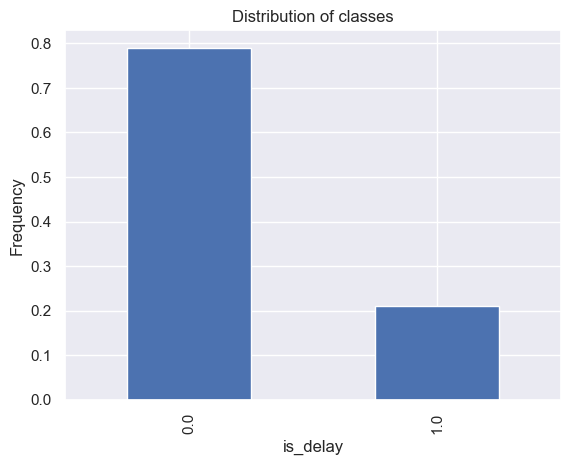

In [43]:
(data.groupby(['is_delay']).size()/len(data) ).plot(kind='bar')# Enter your code here
plt.ylabel('Frequency')
plt.title('Distribution of classes')
plt.show()

Is_delay is from ArrDel15: Arrival Delay Indicator, 15 Minutes or More (1=Yes)

**Question**: What can you deduce from the bar plot about the ratio of delay vs. no delay?

**Answer** There is significant imbalance in dataset, approx 80% having is_delay 'No' and 20% having is_delay indicator 'Yes', delayed 15mins or more. 
When building predictive models on such data, it is important to consider the imbalance, as it could bias my model towards the marjority class. 
May be resampling the data, apply algorithms or techniques like XGBoost that handle imbalanced data well.


**Questions**: 

- Which months have the most delays? June
- What time of the day has the most delays? 20:00
- What day of the week has the most delays? Thursday
- Which airline has the most delays? OO
- Which origin and destination airports have the most delays? Origin:ORD, Destination: SFO
- Is flight distance a factor in the delays? No, the distribution for both class are similar, and there is no noticable difference between delayed or not delayed flight with distance. 

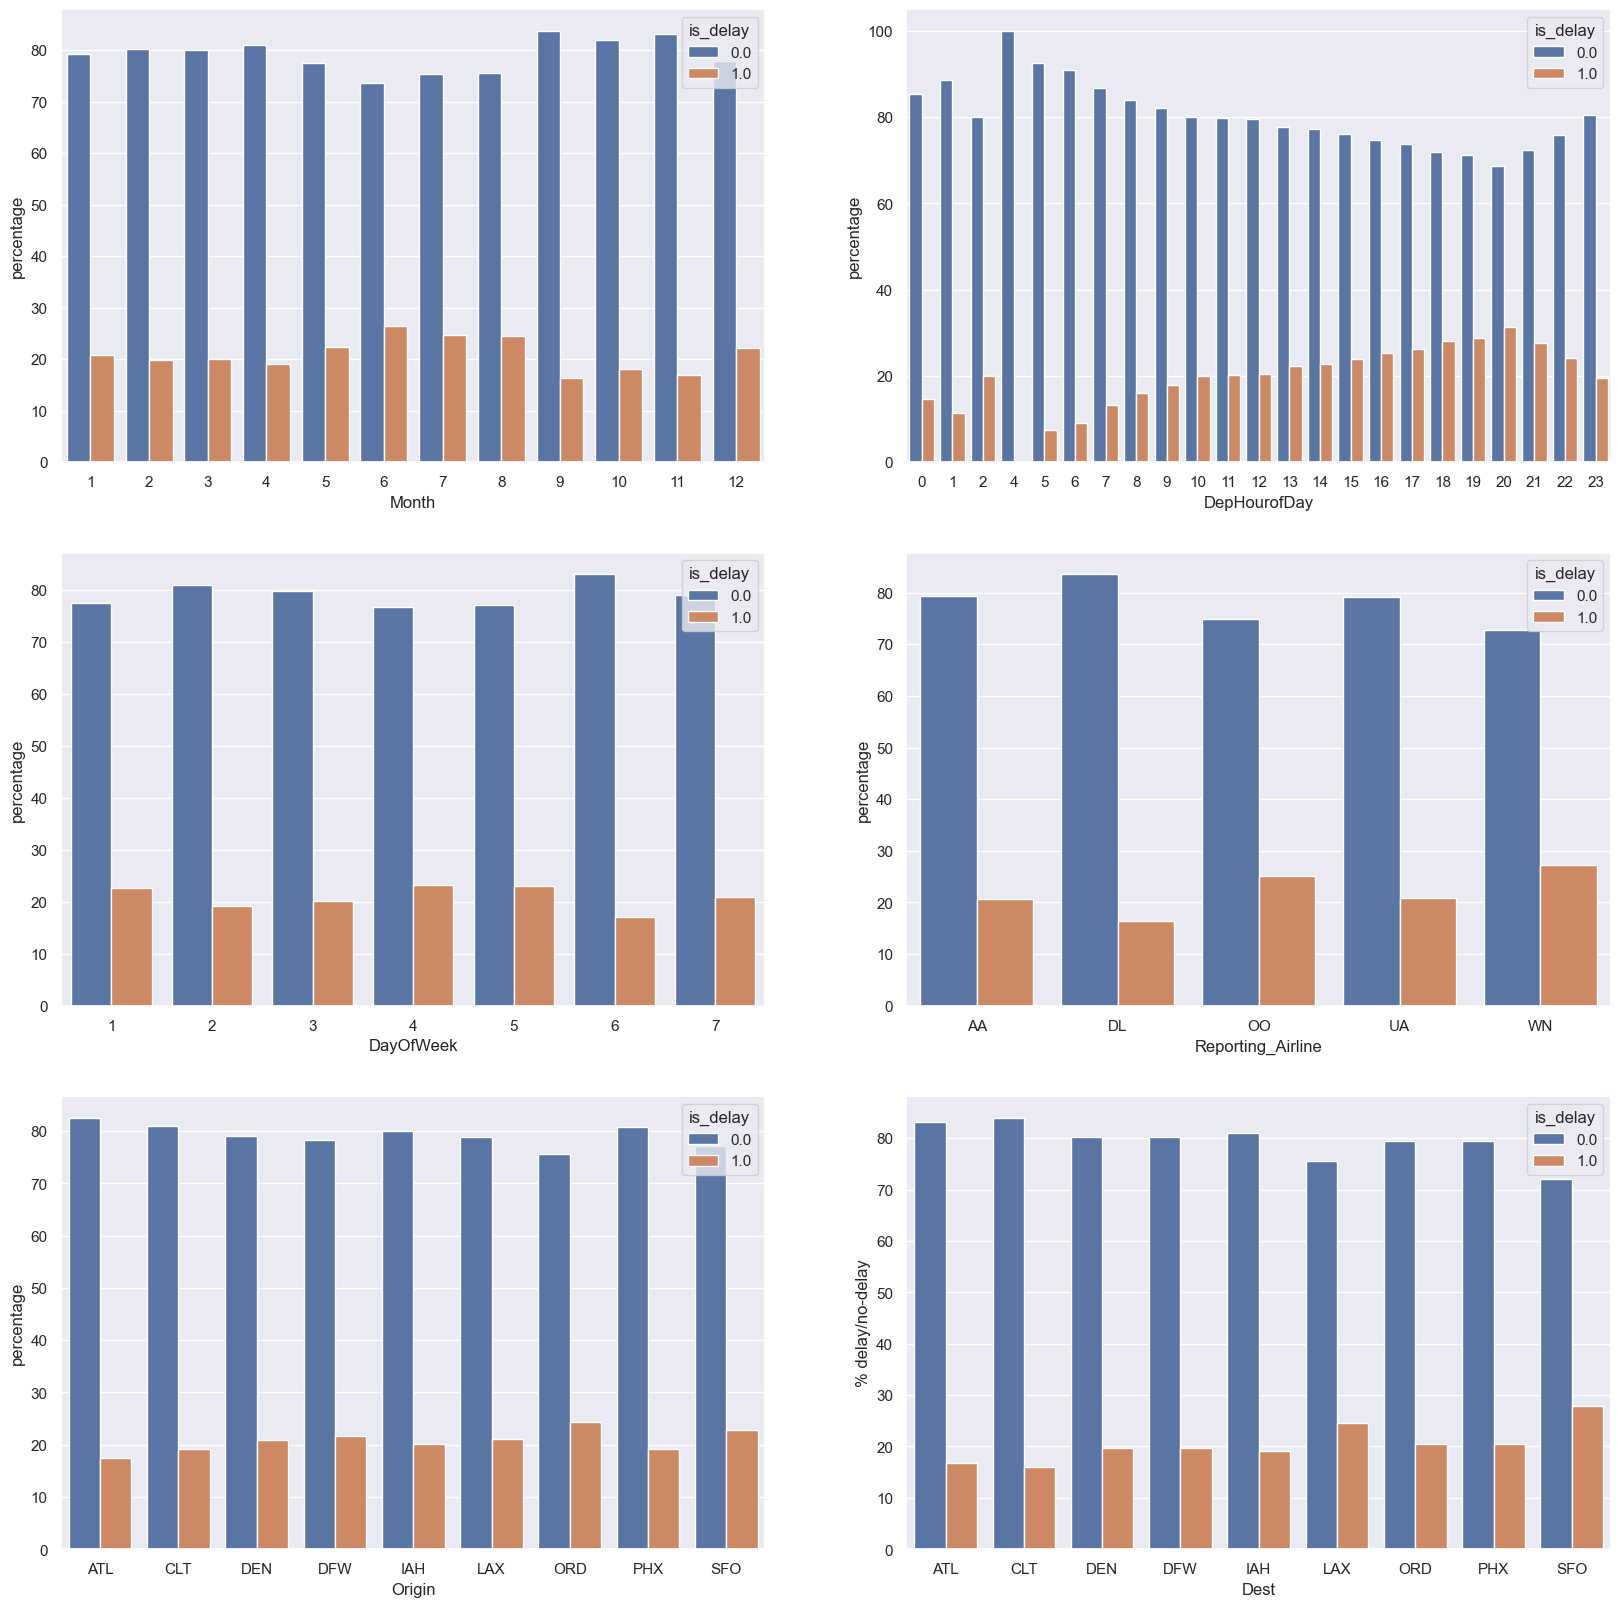

In [44]:
viz_columns = ['Month', 'DepHourofDay', 'DayOfWeek', 'Reporting_Airline', 'Origin', 'Dest']
fig, axes = plt.subplots(3, 2, figsize=(20,20), squeeze=False)
# fig.autofmt_xdate(rotation=90)

for idx, column in enumerate(viz_columns):
    ax = axes[idx//2, idx%2]
    temp = data.groupby(column)['is_delay'].value_counts(normalize=True).rename('percentage').\
    mul(100).reset_index().sort_values(column)
    sns.barplot(x=column, y="percentage", hue="is_delay", data=temp, ax=ax)
    plt.ylabel('% delay/no-delay')
    

plt.show()

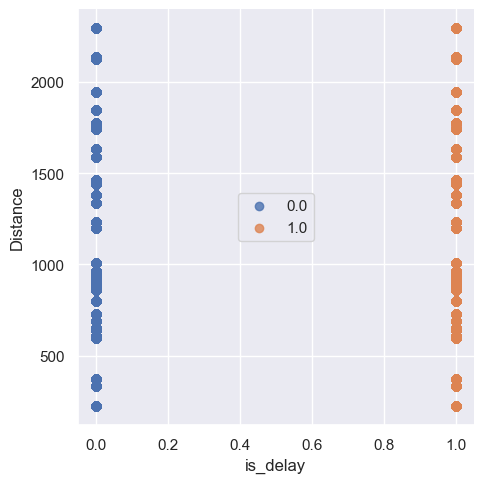

In [45]:
sns.lmplot( x="is_delay", y="Distance", data=data, fit_reg=False, hue='is_delay', legend=False)
plt.legend(loc='center')
plt.xlabel('is_delay')
plt.ylabel('Distance')
plt.show()

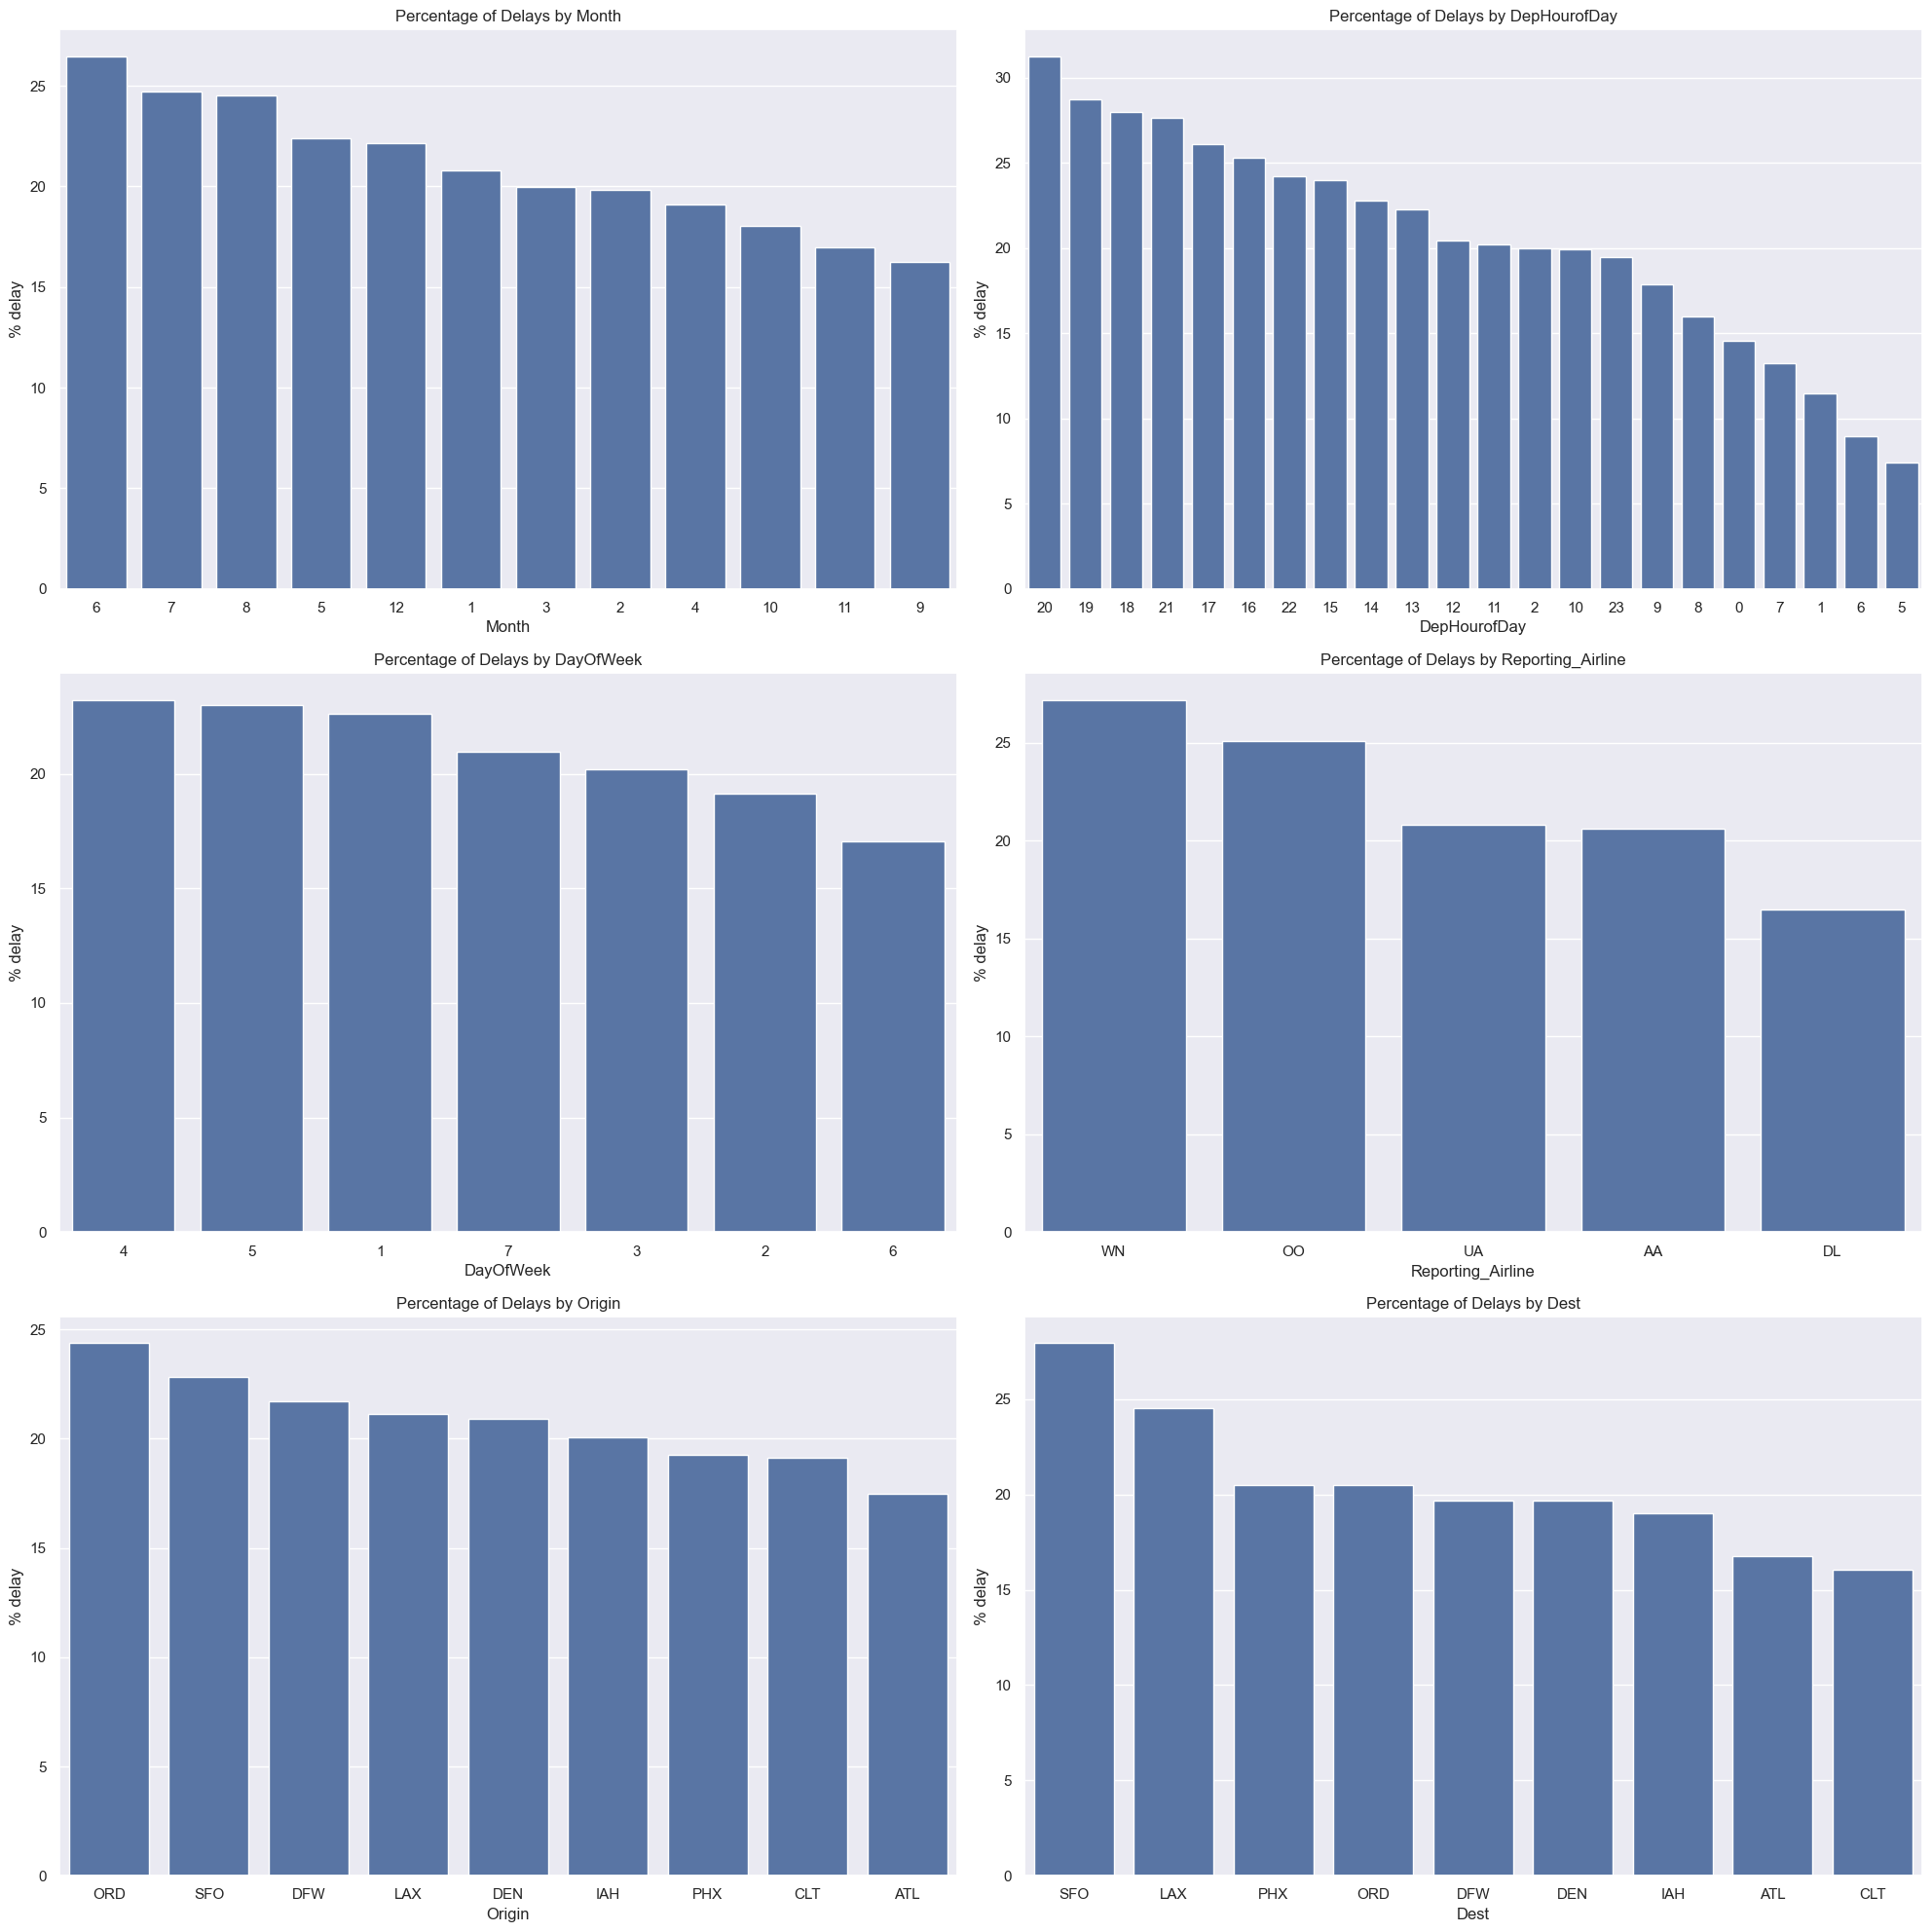

In [46]:
# Based on the above figures, enter your answers to the above questions here and turn the cell type to markdown
# Extended base on above figures for easy visual
viz_columns = ['Month', 'DepHourofDay', 'DayOfWeek', 'Reporting_Airline', 'Origin', 'Dest']
fig, axes = plt.subplots(3, 2, figsize=(20,20), squeeze=False)

for idx, column in enumerate(viz_columns):
    ax = axes[idx//2, idx%2]
    
    # Calculate percentage, filter for 'Yes' in 'is_delay', and sort by 'percentage'
    temp = data.groupby(column)['is_delay'].value_counts(normalize=True).rename('percentage').\
    mul(100).reset_index().sort_values(by='percentage', ascending=False)
    
    temp_delay = temp[temp['is_delay'] == 1]
    
    sns.barplot(x=column, y="percentage", data=temp_delay, ax=ax, order=temp_delay[column])
    ax.set_ylabel('% delay')
    ax.set_title(f'Percentage of Delays by {column}')

plt.tight_layout()
plt.show()

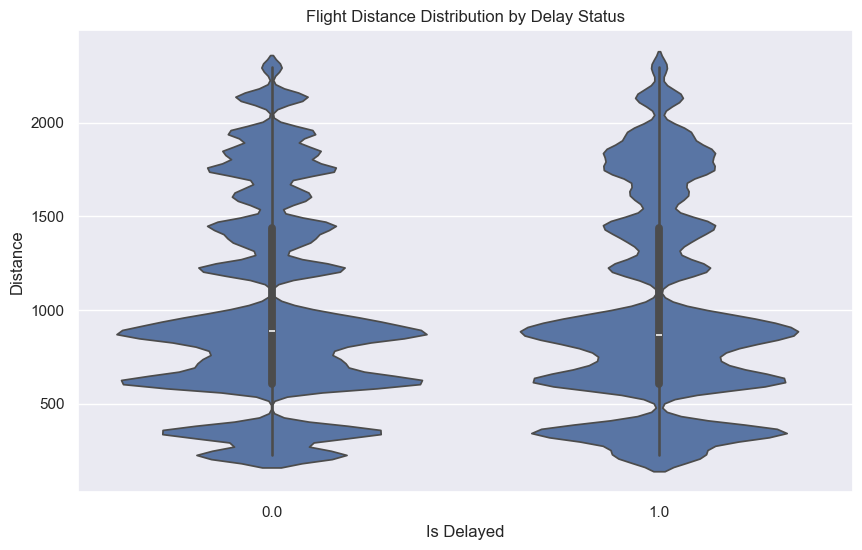

In [47]:
plt.figure(figsize=(10,6))
sns.violinplot(x='is_delay', y='Distance', data=data)
plt.title('Flight Distance Distribution by Delay Status')
plt.xlabel('Is Delayed')
plt.ylabel('Distance')
plt.show()

### Features

Look at all the columns and what their specific types are.

In [48]:
data.columns

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'Reporting_Airline', 'Origin', 'OriginState', 'Dest', 'DestState',
       'CRSDepTime', 'Cancelled', 'Diverted', 'Distance', 'DistanceGroup',
       'ArrDelay', 'ArrDelayMinutes', 'is_delay', 'AirTime', 'DepHourofDay'],
      dtype='object')

In [49]:
data.dtypes

Year                   int64
Quarter                int64
Month                  int64
DayofMonth             int64
DayOfWeek              int64
FlightDate            object
Reporting_Airline     object
Origin                object
OriginState           object
Dest                  object
DestState             object
CRSDepTime            object
Cancelled            float64
Diverted             float64
Distance             float64
DistanceGroup          int64
ArrDelay             float64
ArrDelayMinutes      float64
is_delay             float64
AirTime              float64
DepHourofDay           int32
dtype: object

Filtering the required columns:
- Date is redundant, because you have Year, Quarter, Month, DayofMonth, and DayOfWeek to describe the date.
- Use Origin and Dest codes instead of OriginState and DestState.
- Because you are just classifying whether the flight is delayed or not, you don't need TotalDelayMinutes, DepDelayMinutes, and ArrDelayMinutes.

Treat DepHourofDay as a categorical variable because it doesn't have any quantitative relation with the target.
- If you had to do a one-hot encoding of it, it would result in 23 more columns.
- Other alternatives to handling categorical variables include hash encoding, regularized mean encoding, and bucketizing the values, among others.
- Just split into buckets here.

**Hint**: To change a column type to category, use the `astype` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.astype.html)).

In [50]:
data_orig = data.copy()

In [60]:
#data = data_orig.copy()

In [61]:
data = data[[ 'is_delay', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest','Distance','DepHourofDay']]
categorical_columns  = ['Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest', 'DepHourofDay']
for c in categorical_columns:
    data[c] = data[c].astype('category')# Enter your code here

In [62]:
# Filtering the required columns:
data = data[[ 'is_delay', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest','Distance','DepHourofDay']]
categorical_columns  = ['Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest']
for c in categorical_columns:
    data[c] = data[c].astype('category')# Enter your code here
    

In [63]:
bins =  [0, 4, 8, 12, 16, 20, 24] 
labels = [4, 8, 12, 16, 20, 24]

data['DepHourofDay'] = pd.cut(data['DepHourofDay'], bins, labels=labels, include_lowest=True)
data.DepHourofDay.unique()

[24, 12, 20, 16, 8, 4]
Categories (6, int64): [4 < 8 < 12 < 16 < 20 < 24]

In [64]:
data.isnull().sum(axis=0)

is_delay             0
Quarter              0
Month                0
DayofMonth           0
DayOfWeek            0
Reporting_Airline    0
Origin               0
Dest                 0
Distance             0
DepHourofDay         0
dtype: int64

To use one-hot encoding, use the Pandas `get_dummies` function for the categorical columns that you selected above. Then, you can concatenate those generated features to your original dataset using the Pandas `concat` function. For encoding categorical variables, you can also use *dummy encoding* by using a keyword `drop_first=True`. For more information on dummy encoding, see https://en.wikiversity.org/wiki/Dummy_variable_(statistics).

For example:
```
pd.get_dummies(df[['column1','columns2']], drop_first=True)
```

In [65]:
data_dummies = pd.get_dummies(data[categorical_columns], drop_first=True) 

data = pd.concat([data, data_dummies], axis = 1)
data.drop(categorical_columns,axis=1, inplace=True)

Check the length of the dataset and the new columnms.

In [66]:
data.shape

(1635590, 73)

In [67]:
data.columns

Index(['is_delay', 'Distance', 'DepHourofDay', 'Quarter_2', 'Quarter_3',
       'Quarter_4', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
       'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
       'Reporting_Airline_DL', 'Reporting_Airline_OO', 'Reporting_Airline_UA',
       'Reporting_Airline_WN', 'Origin_CLT

**Sample Answer:** 
```
Index(['Distance', 'is_delay', 'Quarter_2', 'Quarter_3', 'Quarter_4',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7',
       'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
       'Reporting_Airline_DL', 'Reporting_Airline_OO', 'Reporting_Airline_UA',
       'Reporting_Airline_WN', 'Origin_CLT', 'Origin_DEN', 'Origin_DFW',
       'Origin_IAH', 'Origin_LAX', 'Origin_ORD', 'Origin_PHX', 'Origin_SFO',
       'Dest_CLT', 'Dest_DEN', 'Dest_DFW', 'Dest_IAH', 'Dest_LAX', 'Dest_ORD',
       'Dest_PHX', 'Dest_SFO'],
      dtype='object')
```

Now you are ready to do model training. Before splitting the data, rename the column `is_delay` to `target`.

**Hint**: You can use the Pandas `rename` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html)).

In [68]:
data.rename(columns = {'is_delay':'target'}, inplace=True )# Enter your code here

In [70]:
# write code to Save the combined csv file (combined_csv_v1.csv) to your local computer
# note this combined file will be used in part B
data.to_csv('combined_csv_v1.csv',index=False) 
combined_csv_v1 = pd.read_csv('combined_csv_v1.csv')
combined_csv_v1.shape

(1635590, 73)

# Step 3: Model training and evaluation

1. Split the data into `train_data`, and `test_data` using `sklearn.model_selection.train_test_split`.  
2. Build a logistic regression model for the data, where training data is 80%, and test data is 20%.

Use the following cells to complete these steps. Insert and delete cells where needed.


### Train test split

In [71]:
from sklearn.model_selection import train_test_split

In [72]:
# write Code here to split data into train, validate and test
X = combined_csv_v1.drop('target', axis=1)
y = combined_csv_v1['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=14) # 80% training and 20% testing


### Baseline classification model

In [73]:
from sklearn.linear_model import LogisticRegression

In [74]:
# <write code here>
logreg = LogisticRegression(max_iter=10000) # max_iter may need to be increased if the algorithm does not converge.
logreg.fit(X_train, y_train)


LogisticRegression(max_iter=10000)

In [77]:
# Predict results
y_pred= logreg.predict(X_test)

In [83]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn import metrics
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
print("Precision:{0:0.4f}".format(metrics.precision_score(y_test, y_pred, average = 'weighted')))
print("Recall:{0:0.4f}".format(metrics.recall_score(y_test, y_pred, average = 'weighted')))
print("F1-score:{0:0.4f}".format(metrics.f1_score(y_test, y_pred, average = 'weighted')))
report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(report)

Model accuracy score: 0.7898
Precision:0.7200
Recall:0.7898
F1-score:0.6985

Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      1.00      0.88    258401
         1.0       0.46      0.00      0.01     68717

    accuracy                           0.79    327118
   macro avg       0.62      0.50      0.44    327118
weighted avg       0.72      0.79      0.70    327118



## Model evaluation
In this section, you'll evaluate your trained model on test data and report on the following metrics:
* Confusion Matrix plot
* Plot the ROC
* Report statistics such as Accuracy, Percision, Recall, Sensitivity and Specificity

To view a plot of the confusion matrix, and various scoring metrics, create a couple of functions:

In [89]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

In [100]:
def plot_confusion_matrix(test_labels, target_predicted):
    # complete the code here
    # Compute confusion matrix
    cm = confusion_matrix(test_labels, target_predicted)
    
    plt.figure(figsize=(7,7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=['Not Delayed', 'Delayed'], 
                yticklabels=['Not Delayed', 'Delayed'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

In [101]:
def plot_roc(test_labels, target_predicted):
    # complete the code here
    fpr, tpr, _ = roc_curve(test_labels, target_predicted)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    


To plot the confusion matrix, call the `plot_confusion_matrix` function on the `test_labels` and `target_predicted` data from your batch job:

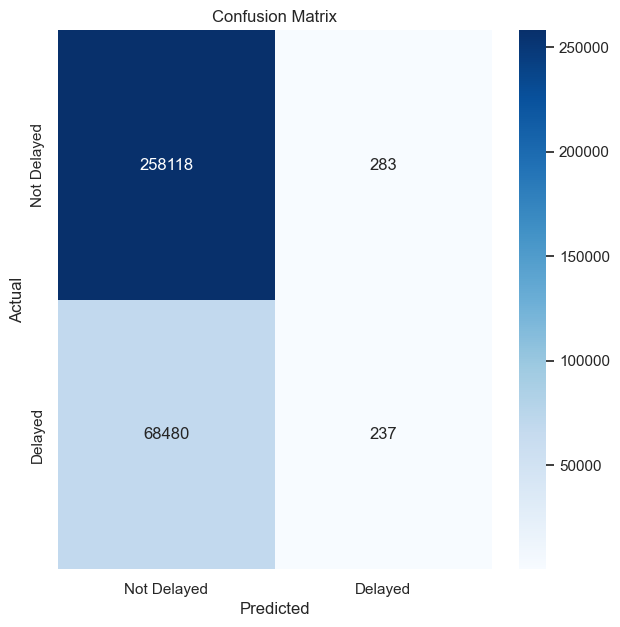

In [102]:
# Enter you code here
plot_confusion_matrix(y_test, y_pred)

To print statistics and plot an ROC curve, call the `plot_roc` function on the `test_labels` and `target_predicted` data from your batch job:

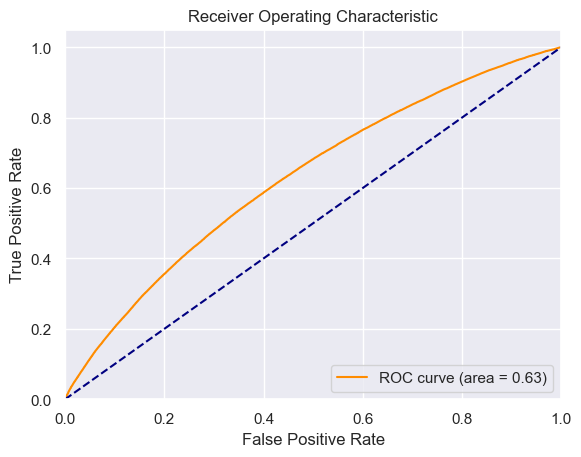

In [103]:
# Enter you code here
y_probs = logreg.predict_proba(X_test)[:, 1]
plot_roc(y_test, y_probs)

### Key questions to consider:
1. How does your model's performance on the test set compare to the training set? What can you deduce from this comparison? 

2. Are there obvious differences between the outcomes of metrics like accuracy, precision, and recall? If so, why might you be seeing those differences? 

3. Is the outcome for the metric(s) you consider most important sufficient for what you need from a business standpoint? If not, what are some things you might change in your next iteration (in the feature engineering section, which is coming up next)? 

Use the cells below to answer these and other questions. Insert and delete cells where needed.


**Question**: What can you summarize from the confusion matrix?


**Answer** The model tends to predicting on time when it actually ends up being 'late', since there are far more false positives than true negatives. This indication that model is biased towards predicting the "not delayed" class as the imbalanced data, which has raised previously in data exploration. it is a common issue in imbalanced datasets, where one class outnumbers the other significantly. 

Accuracy is not bad, which might indicate a good model perforamcne. however, given the class imbalance visible in confusion matrix, accuracy might be misleading. 

Precision for positive class (delayed) is quite low, indicate that when the model predict a delayed instance, it only have 46% correct. 

Recall for positive class is extremly low, showing the model hardly identifies any true Delayed. most of the 'Delayed' are being missed. 68480 FN. 


# Step 4: Deployment

1. In this step you are required to push your source code and requirements file to a GitLab repository without the data files. Please use the Git commands to complete this task
2- Create a “readme.md” markdown file that describes the code of this repository and how to run it and what the user would expect if got the code running.

In the cell below provide the link of the pushed repository on your GitLab account.


#### Provide a link for your Gitlab repository here
https://gitlab.com/masterofdatascience/u3002080_dst_11523_final_project/-/blob/main/onpremises.ipynb

# Iteration II

# Step 5: Feature engineering

You've now gone through one iteration of training and evaluating your model. Given that the outcome you reached for your model the first time probably wasn't sufficient for solving your business problem, what are some things you could change about your data to possibly improve model performance?

### Key questions to consider:
1. How might the balance of your two main classes (delay and no delay) impact model performance?
2. Do you have any features that are correlated?
3. Are there feature reduction techniques you could perform at this stage that might have a positive impact on model performance? 
4. Can you think of adding some more data/datasets?
4. After performing some feature engineering, how does your model performance compare to the first iteration?

Use the cells below to perform specific feature engineering techniques (per the questions above) that you think could improve your model performance. Insert and delete cells where needed.


Before you start, think about why the precision and recall are around 80% while the accuracy is 99%.

#### Add more features

1. Holidays
2. Weather

Because the list of holidays from 2014 to 2018 is known, you can create an indicator variable **is_holiday** to mark these.
The hypothesis is that airplane delays could be higher during holidays compared to the rest of the days. Add a boolean variable `is_holiday` that includes the holidays for the years 2014-2018.

In [107]:
# Source: http://www.calendarpedia.com/holidays/federal-holidays-2014.html

holidays_14 = ['2014-01-01',  '2014-01-20', '2014-02-17', '2014-05-26', '2014-07-04', '2014-09-01', '2014-10-13', '2014-11-11', '2014-11-27', '2014-12-25' ] 
holidays_15 = ['2015-01-01',  '2015-01-19', '2015-02-16', '2015-05-25', '2015-06-03', '2015-07-04', '2015-09-07', '2015-10-12', '2015-11-11', '2015-11-26', '2015-12-25'] 
holidays_16 = ['2016-01-01',  '2016-01-18', '2016-02-15', '2016-05-30', '2016-07-04', '2016-09-05', '2016-10-10', '2016-11-11', '2016-11-24', '2016-12-25', '2016-12-26']
holidays_17 = ['2017-01-02', '2017-01-16', '2017-02-20', '2017-05-29' , '2017-07-04', '2017-09-04' ,'2017-10-09', '2017-11-10', '2017-11-23', '2017-12-25']
holidays_18 = ['2018-01-01', '2018-01-15', '2018-02-19', '2018-05-28' , '2018-07-04', '2018-09-03' ,'2018-10-08', '2018-11-12','2018-11-22', '2018-12-25']
holidays = holidays_14+ holidays_15+ holidays_16 + holidays_17+ holidays_18

### Add indicator variable for holidays
data_orig['is_holiday'] = data_orig['FlightDate'].isin(holidays).astype(int)# Enter your code here 

In [113]:
data_orig[data_orig['is_holiday'] == 1][['FlightDate', 'is_holiday']]

FlightDate  is_holiday
925      2014-01-20           1
926      2014-01-20           1
927      2014-01-20           1
928      2014-01-20           1
1098     2014-01-01           1
...             ...         ...
1657982  2018-09-03           1
1657983  2018-09-03           1
1657984  2018-09-03           1
1657985  2018-09-03           1
1657986  2018-09-03           1

[43912 rows x 2 columns]

Weather data was fetched from https://www.ncei.noaa.gov/access/services/data/v1?dataset=daily-summaries&stations=USW00023174,USW00012960,USW00003017,USW00094846,USW00013874,USW00023234,USW00003927,USW00023183,USW00013881&dataTypes=AWND,PRCP,SNOW,SNWD,TAVG,TMIN,TMAX&startDate=2014-01-01&endDate=2018-12-31.
<br>

This dataset has information on wind speed, precipitation, snow, and temperature for cities by their airport codes.

**Question**: Could bad weather due to rains, heavy winds, or snow lead to airplane delay? Let's check!

In [ ]:
# download data from the link above and place it into the data folder

Import weather data prepared for the airport codes in our dataset. Use the stations and airports below for the analysis, and create a new column called `airport` that maps the weather station to the airport name.

In [118]:
weather = pd.read_csv('daily-summaries-2023-10-22T08-05-21.csv') # Enter your code here to read 'daily-summaries.csv' file

station = ['USW00023174','USW00012960','USW00003017','USW00094846',
           'USW00013874','USW00023234','USW00003927','USW00023183','USW00013881'] 
airports = ['LAX', 'IAH', 'DEN', 'ORD', 'ATL', 'SFO', 'DFW', 'PHX', 'CLT']

### Map weather stations to airport code
station_map = dict(zip(station, airports))
print(station_map)
weather['airport'] =  weather['STATION'].map(station_map)

{'USW00023174': 'LAX', 'USW00012960': 'IAH', 'USW00003017': 'DEN', 'USW00094846': 'ORD', 'USW00013874': 'ATL', 'USW00023234': 'SFO', 'USW00003927': 'DFW', 'USW00023183': 'PHX', 'USW00013881': 'CLT'}


In [120]:
weather.head()

STATION        DATE  AWND  PRCP  SNOW  SNWD   TAVG   TMAX   TMIN  \
0  USW00023174  2014-01-01    16     0   NaN   NaN  131.0  178.0   78.0   
1  USW00023174  2014-01-02    22     0   NaN   NaN  159.0  256.0  100.0   
2  USW00023174  2014-01-03    17     0   NaN   NaN  140.0  178.0   83.0   
3  USW00023174  2014-01-04    18     0   NaN   NaN  136.0  183.0  100.0   
4  USW00023174  2014-01-05    18     0   NaN   NaN  151.0  244.0   83.0   

  airport  
0     LAX  
1     LAX  
2     LAX  
3     LAX  
4     LAX

Create another column called `MONTH` from the `DATE` column.

In [121]:
weather['MONTH'] = weather['DATE'].apply(lambda x: x.split('-')[1])# Enter your code here 
weather.head()

STATION        DATE  AWND  PRCP  SNOW  SNWD   TAVG   TMAX   TMIN  \
0  USW00023174  2014-01-01    16     0   NaN   NaN  131.0  178.0   78.0   
1  USW00023174  2014-01-02    22     0   NaN   NaN  159.0  256.0  100.0   
2  USW00023174  2014-01-03    17     0   NaN   NaN  140.0  178.0   83.0   
3  USW00023174  2014-01-04    18     0   NaN   NaN  136.0  183.0  100.0   
4  USW00023174  2014-01-05    18     0   NaN   NaN  151.0  244.0   83.0   

  airport MONTH  
0     LAX    01  
1     LAX    01  
2     LAX    01  
3     LAX    01  
4     LAX    01

### Sample output
```
  STATION     DATE      AWND PRCP SNOW SNWD TAVG TMAX  TMIN airport MONTH
0 USW00023174 2014-01-01 16   0   NaN  NaN 131.0 178.0 78.0  LAX    01
1 USW00023174 2014-01-02 22   0   NaN  NaN 159.0 256.0 100.0 LAX    01
2 USW00023174 2014-01-03 17   0   NaN  NaN 140.0 178.0 83.0  LAX    01
3 USW00023174 2014-01-04 18   0   NaN  NaN 136.0 183.0 100.0 LAX    01
4 USW00023174 2014-01-05 18   0   NaN  NaN 151.0 244.0 83.0  LAX    01
```

Analyze and handle the `SNOW` and `SNWD` columns for missing values using `fillna()`. Use the `isna()` function to check the missing values for all the columns.

In [123]:
weather.SNOW.fillna(0, inplace=True)# Enter your code here
weather.SNWD.fillna(0, inplace=True)# Enter your code here
weather.isna().sum()

STATION     0
DATE        0
AWND        0
PRCP        0
SNOW        0
SNWD        0
TAVG       62
TMAX       20
TMIN       20
airport     0
MONTH       0
dtype: int64

**Question**: Print the index of the rows that have missing values for TAVG, TMAX, TMIN.

**Hint**: Use the `isna()` function to find the rows that are missing, and then use the list on the idx variable to get the index.

In [125]:
idx = np.array([i for i in range(len(weather))])
TAVG_idx = np.where(weather['TAVG'].isna())
TMAX_idx = np.where(weather['TMAX'].isna())
TMIN_idx = np.where(weather['TMIN'].isna())
TAVG_idx

(array([ 3956,  3957,  3958,  3959,  3960,  3961,  3962,  3963,  3964,
         3965,  3966,  3967,  3968,  3969,  3970,  3971,  3972,  3973,
         3974,  3975,  3976,  3977,  3978,  3979,  3980,  3981,  3982,
         3983,  3984,  3985,  4017,  4018,  4019,  4020,  4021,  4022,
         4023,  4024,  4025,  4026,  4027,  4028,  4029,  4030,  4031,
         4032,  4033,  4034,  4035,  4036,  4037,  4038,  4039,  4040,
         4041,  4042,  4043,  4044,  4045,  4046,  4047, 13420],
       dtype=int64),)

### Sample output

```
array([ 3956,  3957,  3958,  3959,  3960,  3961,  3962,  3963,  3964,
        3965,  3966,  3967,  3968,  3969,  3970,  3971,  3972,  3973,
        3974,  3975,  3976,  3977,  3978,  3979,  3980,  3981,  3982,
        3983,  3984,  3985,  4017,  4018,  4019,  4020,  4021,  4022,
        4023,  4024,  4025,  4026,  4027,  4028,  4029,  4030,  4031,
        4032,  4033,  4034,  4035,  4036,  4037,  4038,  4039,  4040,
        4041,  4042,  4043,  4044,  4045,  4046,  4047, 13420])
```

You can replace the missing TAVG, TMAX, and TMIN with the average value for a particular station/airport. Because the consecutive rows of TAVG_idx are missing, replacing with a previous value would not be possible. Instead, replace it with the mean. Use the `groupby` function to aggregate the variables with a mean value.

In [126]:
weather_impute = weather.groupby(['STATION','MONTH']).agg({'TAVG':'mean','TMAX':'mean', 'TMIN':'mean' }).reset_index()# Enter your code here
weather_impute.head(2)

STATION MONTH       TAVG       TMAX       TMIN
0  USW00003017    01  -2.741935  74.000000 -69.858065
1  USW00003017    02  11.219858  88.553191 -65.035461

Merge the mean data with the weather data.

In [127]:
### get the yesterday's data
weather = pd.merge(weather, weather_impute,  how='left', left_on=['MONTH','STATION'], right_on = ['MONTH','STATION'])\
.rename(columns = {'TAVG_y':'TAVG_AVG',
                   'TMAX_y':'TMAX_AVG', 
                   'TMIN_y':'TMIN_AVG',
                   'TAVG_x':'TAVG',
                   'TMAX_x':'TMAX', 
                   'TMIN_x':'TMIN'})

Check for missing values again.

In [138]:
# convert tuple into array
TAVG_idx_array = TAVG_idx[0]
TMAX_idx_array = TMAX_idx[0]
TMIN_idx_array = TMIN_idx[0]

# Use the arrays for indexing
weather.loc[TAVG_idx_array, 'TAVG'] = weather.loc[TAVG_idx_array, 'TAVG_AVG']
weather.loc[TMAX_idx_array, 'TMAX'] = weather.loc[TMAX_idx_array, 'TMAX_AVG']
weather.loc[TMIN_idx_array, 'TMIN'] = weather.loc[TMIN_idx_array, 'TMIN_AVG']

weather.isna().sum()


STATION     0
DATE        0
AWND        0
PRCP        0
SNOW        0
SNWD        0
TAVG        0
TMAX        0
TMIN        0
airport     0
MONTH       0
TAVG_AVG    0
TMAX_AVG    0
TMIN_AVG    0
dtype: int64

Drop `STATION,MONTH,TAVG_AVG,TMAX_AVG,TMIN_AVG,TMAX,TMIN,SNWD` from the dataset

In [139]:
weather.drop(columns=['STATION','MONTH','TAVG_AVG', 'TMAX_AVG', 'TMIN_AVG', 'TMAX' ,'TMIN', 'SNWD'],inplace=True)

Add the origin and destination weather conditions to the dataset.

In [140]:
### Add origin weather conditions
data_orig = pd.merge(data_orig, weather,  how='left', left_on=['FlightDate','Origin'], right_on = ['DATE','airport'])\
.rename(columns = {'AWND':'AWND_O','PRCP':'PRCP_O', 'TAVG':'TAVG_O', 'SNOW': 'SNOW_O'})\
.drop(columns=['DATE','airport'])

### Add destination weather conditions
data_orig = pd.merge(data_orig, weather,  how='left', left_on=['FlightDate','Dest'], right_on = ['DATE','airport'])\
.rename(columns = {'AWND':'AWND_D','PRCP':'PRCP_D', 'TAVG':'TAVG_D', 'SNOW': 'SNOW_D'})\
.drop(columns=['DATE','airport'])

**Note**: It is always a good practice to check nulls/NAs after joins.

In [141]:
sum(data.isna().any())

0

In [142]:
data_orig.columns

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'Reporting_Airline', 'Origin', 'OriginState', 'Dest', 'DestState',
       'CRSDepTime', 'Cancelled', 'Diverted', 'Distance', 'DistanceGroup',
       'ArrDelay', 'ArrDelayMinutes', 'is_delay', 'AirTime', 'DepHourofDay',
       'is_holiday', 'AWND_O', 'PRCP_O', 'SNOW_O', 'TAVG_O', 'AWND_D',
       'PRCP_D', 'SNOW_D', 'TAVG_D'],
      dtype='object')

Convert the categorical data into numerical data using one-hot encoding.

In [144]:
data_orig.to_csv('combinedv2.csv', index=False)

In [145]:
data = data_orig.copy()
data = data[['is_delay', 'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest','Distance','DepHourofDay','is_holiday', 'AWND_O', 'PRCP_O',
       'TAVG_O', 'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D']]


categorical_columns  = ['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest', 'is_holiday']
for c in categorical_columns:
    data[c] = data[c].astype('category')

In [146]:
data_dummies = pd.get_dummies(data[categorical_columns], drop_first=True)
data_dummies.columns

Index(['Year_2015', 'Year_2016', 'Year_2017', 'Year_2018', 'Quarter_2',
       'Quarter_3', 'Quarter_4', 'Month_2', 'Month_3', 'Month_4', 'Month_5',
       'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11',
       'Month_12', 'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4',
       'DayofMonth_5', 'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8',
       'DayofMonth_9', 'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12',
       'DayofMonth_13', 'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16',
       'DayofMonth_17', 'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20',
       'DayofMonth_21', 'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24',
       'DayofMonth_25', 'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28',
       'DayofMonth_29', 'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2',
       'DayOfWeek_3', 'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6',
       'DayOfWeek_7', 'Reporting_Airline_DL', 'Reporting_Airline_OO',
       'Reporting_Airline_UA', 'Reporting_Airline_WN',

In [148]:
data = pd.concat([data, data_dummies], axis = 1)
data.drop(categorical_columns,axis=1, inplace=True)

### Sample code

```
data_dummies = pd.get_dummies(data[['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'Reporting_Airline', 'Origin', 'Dest', 'is_holiday']], drop_first=True)
data = pd.concat([data, data_dummies], axis = 1)
categorical_columns.remove('is_delay')
data.drop(categorical_columns,axis=1, inplace=True)
```

Check the new columns.

In [149]:
data.columns

Index(['is_delay', 'Distance', 'DepHourofDay', 'AWND_O', 'PRCP_O', 'TAVG_O',
       'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D', 'Year_2015',
       'Year_2016', 'Year_2017', 'Year_2018', 'Quarter_2', 'Quarter_3',
       'Quarter_4', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
       'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayO

### Sample output

```
Index(['Distance', 'DepHourofDay', 'is_delay', 'AWND_O', 'PRCP_O', 'TAVG_O',
       'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D', 'Year_2015',
       'Year_2016', 'Year_2017', 'Year_2018', 'Quarter_2', 'Quarter_3',
       'Quarter_4', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
       'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
       'Reporting_Airline_DL', 'Reporting_Airline_OO', 'Reporting_Airline_UA',
       'Reporting_Airline_WN', 'Origin_CLT', 'Origin_DEN', 'Origin_DFW',
       'Origin_IAH', 'Origin_LAX', 'Origin_ORD', 'Origin_PHX', 'Origin_SFO',
       'Dest_CLT', 'Dest_DEN', 'Dest_DFW', 'Dest_IAH', 'Dest_LAX', 'Dest_ORD',
       'Dest_PHX', 'Dest_SFO', 'is_holiday_1'],
      dtype='object')
```

Rename the `is_delay` column to `target` again. Use the same code as before.

In [150]:
data.rename(columns = {'is_delay':'target'}, inplace=True )# Enter your code here

In [152]:
data.shape

(1635590, 86)

In [153]:
# write code to Save the new combined csv file (combined_csv_v2.csv) to your local computer
# note this combined file will be also used in part B
data.to_csv('combined_csv_v2.csv', index=False)

Create the training and testing sets again.

In [154]:
# Enter your code here
combined_csv_v2 = pd.read_csv('combined_csv_v2.csv')

In [155]:
# Declare source and target variables

X_v2 = combined_csv_v2.drop(['target'],axis=1)#drop the target class from train set
y_v2 = combined_csv_v2['target']

# Split X and y into training and testing datasets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_v2, y_v2, test_size=0.2, random_state=14) # 80% training and 20% testing


### New baseline classifier

Now, see if these new features add any predictive power to the model.

In [156]:
# Instantiate another logistic regression model
classifier2 = LogisticRegression(max_iter=10000) 

In [157]:
# Enter your code here
# fit the model
classifier2.fit(X_train, y_train)

# Predict results
y_pred= classifier2.predict(X_test)
y_pred

array([0., 0., 0., ..., 0., 0., 0.])

Perform the evaluaion as you have done with the previous model and plot/show the same metrics

In [158]:
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
print("Precision:{0:0.4f}".format(metrics.precision_score(y_test, y_pred, average = 'weighted')))
print("Recall:{0:0.4f}".format(metrics.recall_score(y_test, y_pred, average = 'weighted')))
print("F1-score:{0:0.4f}".format(metrics.f1_score(y_test, y_pred, average = 'weighted')))
report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(report)

Model accuracy score: 0.7925
Precision:0.7480
Recall:0.7925
F1-score:0.7187

Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.99      0.88    258401
         1.0       0.56      0.06      0.10     68717

    accuracy                           0.79    327118
   macro avg       0.68      0.52      0.49    327118
weighted avg       0.75      0.79      0.72    327118



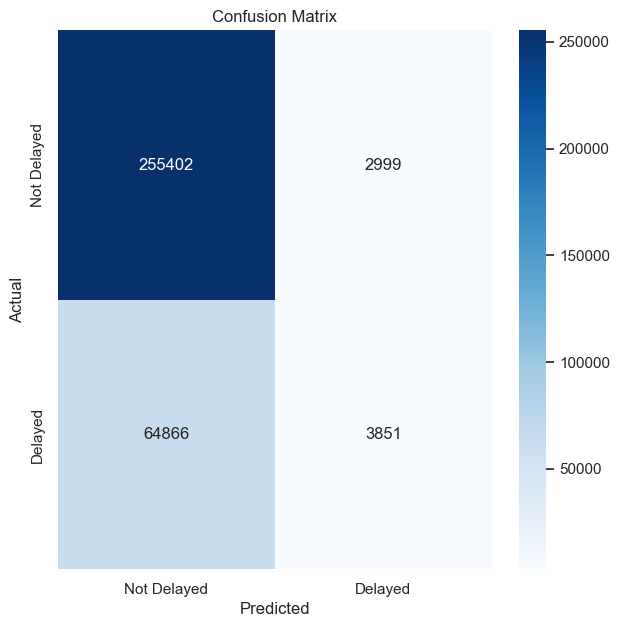

In [159]:
plot_confusion_matrix(y_test, y_pred)

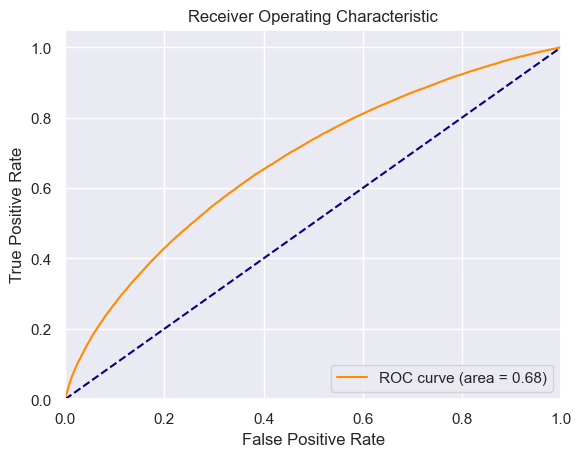

In [160]:
y_probs = classifier2.predict_proba(X_test)[:, 1]
plot_roc(y_test, y_probs)

Question: did you notice a difference by adding the extra data on the results?

Accuracy increased slightly, from 0.7898 to 0.7925, indicating with addtion of weather features, the model improve slightly. 

Precision has improved from 0.46 to 0.56, means positive identifications improved from 46% to 56%, suggests that inclusion of weather data helped model make fewer false-positive predicitions for flights been delayed. 

Recal remains low, 0.00 to 0.06, means the actual positives that were identified correctly. indicate there are still large number of flight delays that model is not capturing 

F1 score has increased from 0.01 to 0.10, even it improved, but it still very low, suggest model performance in identify delayed flight is still not strong. 

From confusion matrix, the number of TP increased from 237 to 3851, and false negative decreased from 68480 to 64866. this is a very positive sign, indicating the model now correlty identifying more delayed flights. however, the number of false negative is still high.

In conclusion, inclusion of weather features appears to have provided improvement, particularly in reducing False positives. however, correctly identify delayed flights is still a challenge. 

# Step 6: Using Tableau

Use Tableau to load the combined_csv_v2.csv file and build a dashboard that show your understanding of the data and business problem. 
### what to do:
1. Load the data into Tableau and build the dashboard
2. Share the dashboard on your Tableau public account 
3. Copy the link of the shared dashboard below

Note: The dashboard needs to be self explainable to others, so make it simple and add only the features that you feel heighlight the main question(s) of the prblem statement.

https://public.tableau.com/app/profile/chen.chen3860/viz/u3002080_DST_11523_Final_Project/Dashboard1?publish=yes

## Conclusion

You've now gone through at least a couple iterations of training and evaluating your model. It's time to wrap up this project and reflect on what you've learned and what types of steps you might take moving forward (assuming you had more time). Use the cell below to answer some of these and other relevant questions:

1. Does your model performance meet your business goal? If not, what are some things you'd like to do differently if you had more time for tuning?
2. To what extent did your model improve as you made changes to your dataset? What types of techniques did you employ throughout this project that you felt yielded the greatest improvements in your model?
3. What were some of the biggest challenges you encountered throughout this project?
4. What were the three most important things you learned about machine learning while completing this project?

**Model Performance and Business Goal:**
The model performance, with an accuracy of around 79.25%, has shown promise, but has not fully achieved our business objective of maximum customer satisfaction through precise flight delay predictions. The issue of false negatives is still crutial, since there are still large number of flight actually delayed, but still predicted on time.  If provided with more data and time for tuning, experimentation with different algorithms known for handling imbalanced data better or employing strategies like data ugmentation, or utilizing a more diverse range of data could potentially improve performance.

**Improvements and Effective Techniques:**
The model showed noticeable improvement with the inclusion of weather-related data, highlighting the importance of feature selection in model performance. Other techniques used in project such as data cleaning, handling missing values, exploratory data analysis, and iterative model training also contributed to these improvements. furthermore, learning to leverage other methodologies or algorithms, especially those effective with imbalanced datasets could be instrumental in future improvements. 

**Challenges:**
Handling the volumn of the data, navigating through missing or incosistent records, determining the features that influence flight delays were challenging, a more challenge was the imbalanced natrue of the dataset, balancing the precision and recall to reduce false negatives presented difficulty. More reasearch and experimentation are required to adeptly handle this imbalance to enhance the model performance. 

**Learning Outcomes:**
Throughout this project, the critical learnings were: a) data preprocessing, from unzip the volumnious dataset, to handling missing data. b) the necessity of iterative processes in model testing and tuning for achieving better performance, and c) the cirtical role of domain knowledge in feature selection and interpreting model predictions, using business goal drive the machine learning objectives. Additionally, the imbalanced dataset bias the model towards the majority class, highlighted the need for specific strategies to counteract this. 